In [151]:
from biolearn.data_library import DataLibrary
import pickle
from tqdm import tqdm
import textwrap

In [166]:
gse = 'GSE52588'
data_source = DataLibrary().get(gse)

print(textwrap.fill(data_source.summary, 70))
data=data_source.load()

Down syndrome is characterized by a wide spectrum of clinical signs,
which include cognitive and endocrine disorders and haematological
abnormalities. Although it is well established that the causative
defect of Down syndrome is the trisomy of chromosome 21, the molecular
bases of Down syndrome phenotype are still largely unknown. We used
the Infinium HumanMethylation450 BeadChip to investigate DNA
methylation patterns in whole blood from 29 subjects affected by Down
syndrome (DS), using their healthy relatives as controls (mothers  and
unaffected siblings). This family-based model allowed us to monitor
possible confounding effects on DNA methylation patterns deriving from
genetic and environmental (lifestyle) factors. The identified
epigenetic signature of Down syndrome includes differentially
methylated regions that, although enriched on chromosome 21, interest
most of the other chromosomes and can be functionally linked to the
developmental and haematological defects characteristic 

In [167]:
data_obj = {}
data_obj['data'] = data.dnam
data_obj['meta'] = data.metadata

In [168]:
pickle.dump(data_obj, open(f'data/{gse}.pkl', 'wb'))

In [169]:
#now load it
data_obj = pickle.load(open(f'data/{gse}.pkl', 'rb'))

In [171]:
data_obj['meta']['disease_state']#.value_counts()

id
GSM1272122    Down syndrome
GSM1272123    Down syndrome
GSM1272124    Down syndrome
GSM1272125    Down syndrome
GSM1272126    Down syndrome
                  ...      
GSM1272204          healthy
GSM1272205          healthy
GSM1272206          healthy
GSM1272207          healthy
GSM1272208          healthy
Name: disease_state, Length: 87, dtype: object

In [172]:
from biolearn.model_gallery import ModelGallery
gallery = ModelGallery()
#Note that by default clocks will impute missing data.
#To change this behavior set the imputation= parameter when getting the clock
keys = list(gallery.model_definitions.keys())
predictions = {}
for k in tqdm(keys):
    try:
        if gallery.model_definitions[k]['output']=='Age (Years)':
            results = gallery.get(k).predict(data)
            predictions[k] = results['Predicted']
    except:
        print('Oops!')
        continue


100%|██████████| 25/25 [00:07<00:00,  3.16it/s]


In [41]:
import pandas as pd
pd.DataFrame(gallery.model_definitions).T

,year,species,tissue,source,output,model
Horvathv1,2013,Human,Multi-tissue,https://genomebiology.biomedcentral.com/articl...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ho..."
Hannum,2013,Human,Blood,https://www.sciencedirect.com/science/article/...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ha..."
Lin,2016,Human,Blood,https://www.aging-us.com/article/100908/text,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Li..."
PhenoAge,2018,Human,Blood,https://www.aging-us.com/article/101414/text,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ph..."
YingCausAge,2022,Human,Blood,https://www.biorxiv.org/content/10.1101/2022.1...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Yi..."
YingDamAge,2022,Human,Blood,https://www.biorxiv.org/content/10.1101/2022.1...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Yi..."
YingAdaptAge,2022,Human,Blood,https://www.biorxiv.org/content/10.1101/2022.1...,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Yi..."
Horvathv2,2018,Human,Skin + blood,https://www.aging-us.com/article/101508/text,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'Ho..."
PEDBE,2019,Human,Buccal,https://www.pnas.org/doi/10.1073/pnas.1820843116,Age (Years),"{'type': 'LinearMethylationModel', 'file': 'PE..."
Zhang_10,2019,Human,Blood,https://www.nature.com/articles/ncomms14617,Mortality Risk,"{'type': 'LinearMethylationModel', 'file': 'Zh..."


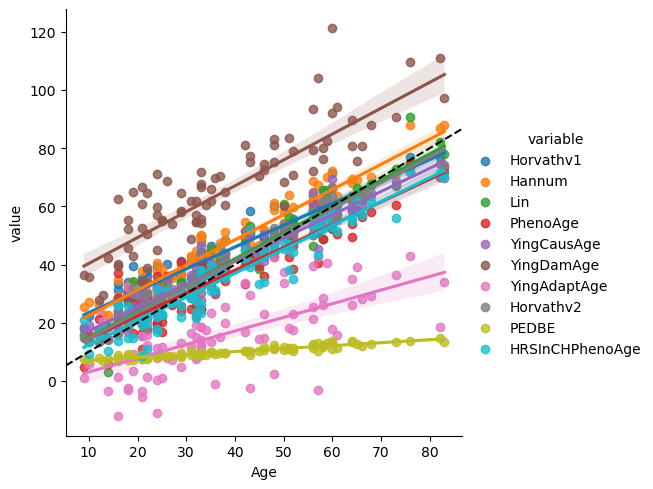

In [174]:
import seaborn as sn
from matplotlib import pyplot as plt
import pandas as pd


plot_data = pd.DataFrame(predictions)
plot_data['Age'] = data.metadata['age']
plot_data['Disease'] = data.metadata['disease_state']
disease_data = plot_data[plot_data['Disease'] == 'Down syndrome'].drop('Disease', axis=1) #schiszofrenia
plot_data_melted = pd.melt(plot_data, id_vars=['Age', 'Disease'])

sn.lmplot(data=plot_data_melted, x='Age', y='value', hue='variable');
plt.axline([20, 20], [70, 70], ls='--', color='k')

In [137]:
from scipy.stats import mannwhitneyu
mannwhitneyu([10,12,9], [4,5,6,7,2,1,3], alternative='greater')

MannwhitneyuResult(statistic=21.0, pvalue=0.008333333333333333)

In [146]:
from scipy.stats import ranksums, wilcoxon

wilcoxon([1,10,0.0001,0.0001,0.1], alternative='greater')

WilcoxonResult(statistic=15.0, pvalue=0.03125)

In [148]:
def single_dataset_benchmarking():
    pass
    

,Horvathv1,Hannum,Lin,PhenoAge,YingCausAge,YingDamAge,YingAdaptAge,Horvathv2,PEDBE,HRSInCHPhenoAge,Age
GSM1009660,30.452585,35.009794,22.481143,28.115610,30.434049,34.902735,31.086773,31.937480,9.311110,29.357422,32.0
GSM1009661,24.820739,25.911236,15.589432,19.577701,18.265357,47.760207,7.942192,25.658929,8.164568,14.805392,24.0
GSM1009662,65.401855,65.536941,50.431606,60.543320,52.875835,54.596133,48.858212,66.537082,15.503905,66.994001,65.0
GSM1009663,23.173561,15.512122,15.228030,11.743696,16.651125,40.692965,-8.574770,19.032609,6.310605,8.994985,25.0
GSM1009664,32.450846,31.191178,24.324188,27.496016,31.998270,62.761372,1.637749,27.045364,8.590446,30.087520,32.0
...,...,...,...,...,...,...,...,...,...,...,...
GSM1009740,31.631162,29.981612,31.311439,30.648356,22.990395,48.325120,11.879204,23.230279,8.318810,28.005342,26.0
GSM1009741,26.312627,23.818356,18.986301,15.770317,18.361857,17.301181,26.042993,21.748744,8.335067,13.413227,32.0
GSM1009890,25.879032,27.949780,28.400974,21.455877,22.560465,23.554604,19.955139,22.437033,8.139275,20.685244,27.0
GSM1009891,33.055429,28.057966,26.933006,20.018195,19.344812,37.818414,21.896244,27.015459,8.219594,28.613943,29.0


In [179]:
from scipy.stats import mannwhitneyu

y = disease_data['Age']
for c in disease_data.columns[:-1]:
    x = disease_data[c]
    # stat, pval = mannwhitneyu(x, y, alternative='greater') #has greater power than wilcoxon
    stat, pval = wilcoxon(x - y, alternative='greater')
    print(f'{c}, pval = {round(pval, 5)}')


Horvathv1, pval = 0.0
Hannum, pval = 0.0
Lin, pval = 0.0
PhenoAge, pval = 0.0
YingCausAge, pval = 0.0
YingDamAge, pval = 0.0
YingAdaptAge, pval = 1.0
Horvathv2, pval = 0.0
PEDBE, pval = 1.0
HRSInCHPhenoAge, pval = 0.00176


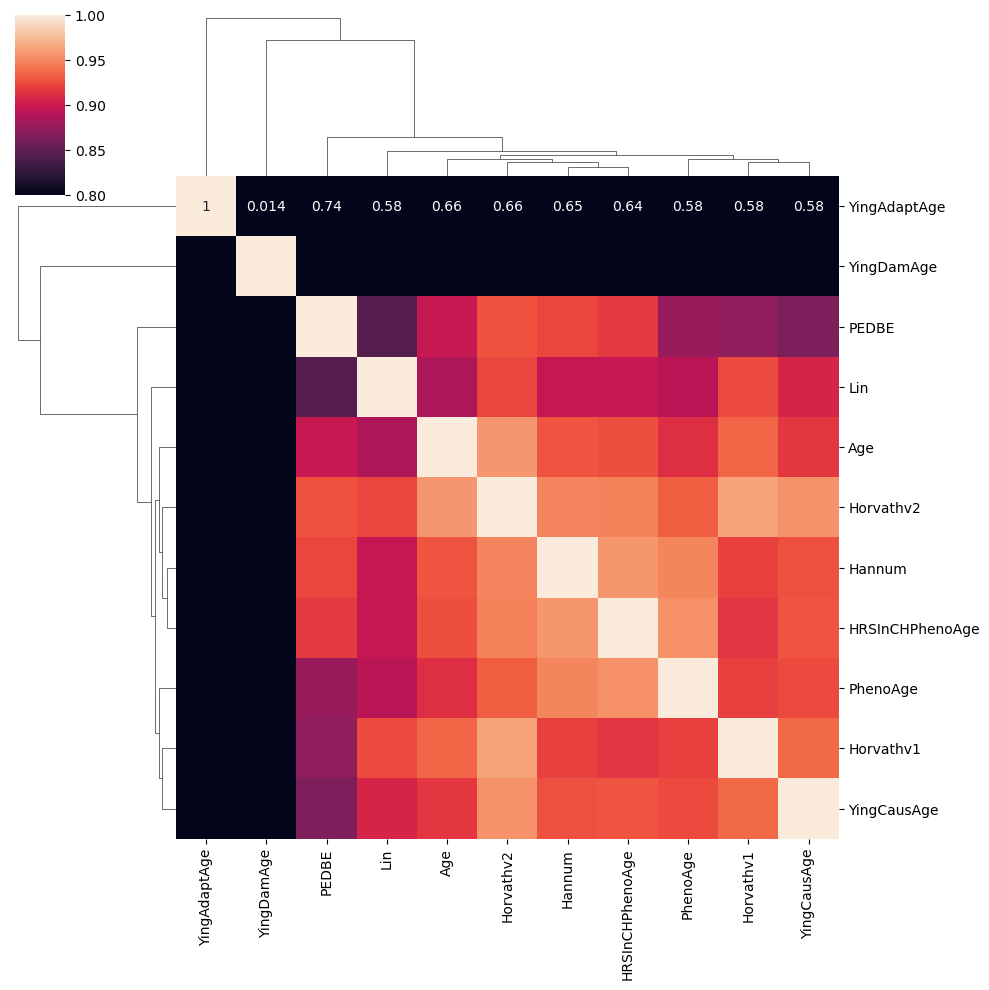

In [72]:
sn.clustermap(plot_data.corr(), annot=True, vmin=0.8)